In [5]:
import pandas as pd
import numpy as np
import os 
import sys
import glob 
import json
import importlib
import tqdm
import warnings
import matplotlib.pyplot as plt
import rapidfuzz as rf

In [6]:
#Make sure to run this only once, to make lobbying-market the working directory
parent_dir_name=os.path.basename(os.path.dirname(os.getcwd()))
if parent_dir_name=='lobbying-market':
    os.chdir(os.path.pardir)
    print(os.getcwd())
    utils_path= os.path.abspath('utils')
    sys.path.append(utils_path)

import preprocessing as pp
importlib.reload(pp)

with open("LDA_data/issue_list.json", 'r') as f:
    issue_list = json.load(f)

issue_df=pd.read_csv('LDA_data/data_by_issue.csv',index_col="issue")

In [7]:
path_pattern='LDA_data/Filings_'
dirdict={str(i):path_pattern + str(i) for i in range(2013,2024)}
filepath_lists = {
    yearkey:
        [dirdict.get(yearkey)+'/'+filepath for filepath in os.listdir(dirdict.get(yearkey))] 
    for yearkey in dirdict
}

index_dict={
    'Q'+str(i+1): [6*i+j for j in range(6)]+[2*i+j for j in range(24,26)] for i in range(4)
}


file_list_dependency={
    yr_key : {
       qt_key:
           [filepath_lists[yr_key][i] for i in index_dict[qt_key]]
    for qt_key in index_dict
    }
    for yr_key in filepath_lists
}


In [8]:
try: preprocessed_file_dict.keys()
except: preprocessed_file_dict={}
dir_path='LDA_data/processed'
filelist= os.listdir(dir_path)
for yr in range(2013,2024):
    for j in range(4):
        key=str(yr)+str(j+1)
        i=(yr-2013)*4+j
        preprocessed_file_dict[key]=dir_path+'/'+filelist[i]  

In [9]:
#LOAD FILES SHORTCUT
with open("LDA_data/client_dict.json", 'r') as f:
    client_dict = json.load(f)
print(len(client_dict))

with open("LDA_data/company_name_dict.json", 'r') as f:
    company_name_dict = json.load(f)
len(company_name_dict)

with open("LDA_data/company_name_dict_with_ids.json", 'r') as f:
    company_name_dict_with_ids = json.load(f)
len(company_name_dict_with_ids)



57732


1460

In [ ]:
#df=pp.preprocess_data(pd.read_csv(file_list_dependency['2023']['Q4'][6]))
#This saves the preprocessed data into csv files
#It also saves the issue list
os.makedirs('LDA_data/processed', exist_ok=True) 
warnings.filterwarnings('ignore')
issue_set=set([])
Year_Keys=list(file_list_dependency.keys())
for yr_key in tqdm.tqdm(Year_Keys, desc = 'YEARS'):
    #print(yr_key)
    QT_Keys=list(file_list_dependency[yr_key].keys())
    for qt_key in tqdm.tqdm(QT_Keys ,desc = 'Quarters'):
        #print(qt_key)
        df=pp.preprocess_data(pd.read_csv(file_list_dependency[yr_key][qt_key][6]))
        filepath= 'LDA_data/processed/filings_'+yr_key+'_'+qt_key+'.csv'
        df.to_csv(filepath,index=False)
        issue_subset= set([col_name for col_name in df.columns if col_name.find('i_')>-1])
        issue_set= issue_set.union(issue_subset)

issue_set.remove('i_NUMBER')
issue_list=list(issue_set)
with open("LDA_data/issue_list.json", 'w') as f:
    json.dump(issue_list, f, indent=2)

In [8]:
#builds the file list to load additional files
files_to_avoid=[]
for yr_key in file_list_dependency:
    for qt_key in file_list_dependency[yr_key]:
        files_to_avoid.append(file_list_dependency[yr_key][qt_key][6])
for yr_key in filepath_lists:
    list_to_add= [path for path in filepath_lists[yr_key] if path not in files_to_avoid]
    try: additional_file_list=additional_file_list+list_to_add
    except: additional_file_list=list_to_add

In [ ]:
#This saves the preprocessed additional data into csv files
# from additional_file_list
dirpath='LDA_data/processed_additional'
os.makedirs(dirpath, exist_ok=True) 
warnings.filterwarnings('ignore')
for path in tqdm.tqdm(additional_file_list):
        df=pp.preprocess_data(pd.read_csv(path))
        filename=os.path.basename(path)
        filepath= dirpath+'/'+filename
        df.to_csv(filepath,index=False)  


In [38]:
def add_data_by_issue(df,qt_key):
    df_to_load= pd.read_csv(preprocessed_file_dict[qt_key])
    #print(df_to_load.shape)
    for issue_key in df['issue']:
        #print(issue_key)
        #filter by issue==1
        filtered_df= df_to_load[df_to_load[issue_key] == 1]
        
                
        #count the rows in issue and add to dataframe
        issue_count= filtered_df.shape[0]
        col_name= 'count_'+qt_key
        try: len(column_list_dict[colname])
        except: column_list_dict[colname]=[]
        df.loc[issue_df['issue']==issue_key,col_name]=issue_count
        #print(col_name+':'+str(issue_count))
        
        
        #count the number of na in both income and expenses then add to dataframe
        filter_na_income=filtered_df[filtered_df['income'].isna()]
        filter_na_expenses=filter_na_income[filter_na_income['expenses'].isna()]
        issue_count_na = filter_na_expenses.shape[0]
        col_name= 'nan_'+qt_key
        df.loc[issue_df['issue']==issue_key,col_name]=issue_count_na
        #print(col_name+':'+str(issue_count_na))
        
        #sum income then add to dataframe
        issue_income= sum(filtered_df['income'].dropna())
        col_name= 'income_'+qt_key
        df.loc[issue_df['issue']==issue_key,col_name]=issue_income
        #print(col_name +':'+str(issue_income))
        
        #sum expenses then add to dataframe
        issue_expenses= sum(filtered_df['expenses'].dropna())
        col_name= 'expenses_'+qt_key
        df.loc[issue_df['issue']==issue_key,col_name]=issue_expenses
        #print(col_name+':'+str(issue_expenses))
        
        #sum total then add to dataframe
        issue_total=issue_income+issue_expenses
        col_name= 'total_'+qt_key
        df.loc[issue_df['issue']==issue_key,col_name]=issue_total
        
        
        
    

In [12]:
warnings.filterwarnings('ignore')
issue_df= pd.DataFrame(issue_list,columns=['issue'])
#add data to issue_df
for qt_key in tqdm.tqdm(preprocessed_file_dict):
    add_data_by_issue(issue_df,qt_key)

100%|██████████| 44/44 [00:42<00:00,  1.04it/s]


In [14]:
issue_df.to_csv('LDA_data/data_by_issue.csv',index=False)

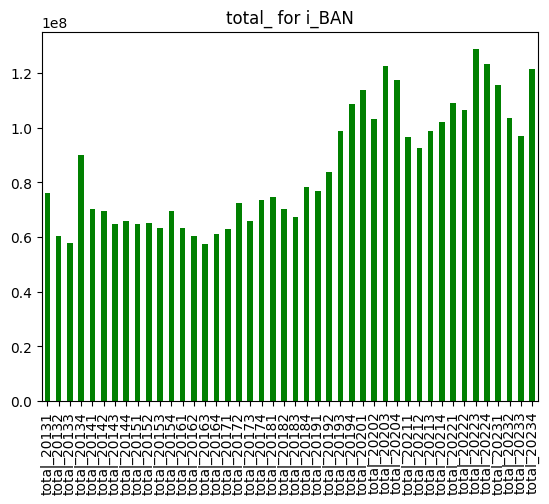

In [49]:
test_cols= issue_df.columns
prop_to_plot='total_'
issue_to_plot='i_BAN'
select_cols_list=[col for col in test_cols if col.find(prop_to_plot)>-1]
filtered_df=issue_df[select_cols_list].transpose()


# bar plot
filtered_df[issue_to_plot].plot(kind='bar',
        x='qt_key',
        y=prop_to_plot,
        color='green')
 
# set the title
plt.title(prop_to_plot + ' for ' +issue_to_plot)
 
# show the plot
plt.show()



In [9]:
client_dict={}

In [ ]:
with open("LDA_data/client_dict.json", 'r') as f:
    client_dict = json.load(f)
print(len(client_dict))

57732

In [6]:
def add_clients_each_quarter(dict,qt_key):
    df_to_load= pd.read_csv(preprocessed_file_dict[qt_key])
    num_of_rows=df_to_load.shape[0]
    #print(df_to_load.shape)
    column_list=['c_id','c_name']
    filtered_df= df_to_load[column_list]
    for i in range(num_of_rows):
        list_a = filtered_df.loc[i]
        try: 
            if list_a['c_name'] not in dict[str(list_a['c_id'])] : 
                dict[str(list_a['c_id'])].append(list_a['c_name'])
        except: dict[str(list_a['c_id'])]=[list_a['c_name']]
        
            
        
        
        
    

In [7]:
def add_clients_by_path(dict,path):
    df_to_load= pd.read_csv(path)
    num_of_rows=df_to_load.shape[0]
    #print(df_to_load.shape)
    column_list=['c_id','c_name']
    filtered_df= df_to_load[column_list]
    for i in range(num_of_rows):
        list_a = filtered_df.loc[i]
        try: 
            if list_a['c_name'] not in dict[str(list_a['c_id'])] : 
                dict[str(list_a['c_id'])].append(list_a['c_name'])
        except: dict[str(list_a['c_id'])]=[list_a['c_name']]

In [15]:
qt_key='20234'
df_to_load= pd.read_csv(preprocessed_file_dict[qt_key])
num_of_rows=df_to_load.shape[0]
#print(df_to_load.shape)
column_list=['c_id','c_name']
filtered_df= df_to_load[column_list]
for i in range(num_of_rows):
    list_a = filtered_df.loc[i]
    try: 
        if list_a['c_name'] not in client_dict[str(list_a['c_id'])] : 
            client_dict[str(list_a['c_id'])].append(list_a['c_name'])
    except: client_dict[str(list_a['c_id'])]=[list_a['c_name']]

C:\Users\nicoj\AppData\Local\Temp\ipykernel_36160\1123778754.py:2: DtypeWarning: Columns (140) have mixed types. Specify dtype option on import or set low_memory=False.
  df_to_load= pd.read_csv(preprocessed_file_dict[qt_key])


In [10]:
client_dict['209471'].remove('WESTERN STATES REGIONAL COUNCIL OF CARPENTERS (FORMERLY KNOWN AS SWMSRCC)')

In [13]:
for key in client_dict:
    client_dict[key]=rf.utils.default_process(client_dict[key])

In [28]:
client_df= pd.DataFrame.from_dict(client_dict, orient='index', columns=['c_name'])
client_df.index.names = ['c_id']

In [30]:
client_df.to_csv('LDA_data/client_name_hash.csv')

TypeError: Index does not support mutable operations

In [ ]:
for qt_key in tqdm.tqdm(preprocessed_file_dict):
    add_clients_each_quarter(client_dict,qt_key)

In [14]:
with open("LDA_data/client_dict.json", 'w') as f:
    json.dump(client_dict, f, indent=2)

In [22]:
57732-len(client_dict)

0

In [17]:
client_dict={}

In [20]:
#all relevant files list
dirpath1='LDA_data/processed_additional'
filelist1= [dirpath1+'/'+filename for filename in os.listdir(dirpath1) ]
dirpath2='LDA_data/processed'
filelist2= [dirpath2+'/'+filename for filename in os.listdir(dirpath2) ]
loadfilelist=filelist1+filelist2

In [ ]:
for path in tqdm.tqdm(loadfilelist):
    add_clients_by_path(client_dict,path)

In [39]:
registrant_dict={}

In [40]:
def add_registrant_by_path(dict,path):
    df_to_load= pd.read_csv(path)
    num_of_rows=df_to_load.shape[0]
    #print(df_to_load.shape)
    column_list=['r_id','r_name','c_id']
    filtered_df= df_to_load[column_list]
    for i in range(num_of_rows):
        list_a = filtered_df.loc[i]
        registrant_id_key=str(list_a['r_id'])
        registrant_name_key=str(list_a['r_name'])
        client_id_key=str(list_a['c_id'])
        if registrant_id_key not in dict.keys():
            dict[registrant_id_key]=[[],[]]
        if registrant_name_key not in dict[registrant_id_key][0]: 
                dict[registrant_id_key][0].append(registrant_name_key)
        if client_id_key not in dict[registrant_id_key][1]: 
                dict[registrant_id_key][1].append(client_id_key)

In [ ]:
for path in tqdm.tqdm(loadfilelist):
    add_registrant_by_path(registrant_dict,path)

In [49]:
with open("LDA_data/registrant_dict.json", 'w') as f:
    json.dump(registrant_dict, f, indent=2)

In [43]:
len(registrant_dict)

8431

In [44]:
sum([len(registrant_dict[key][1])for key in registrant_dict])

57732

In [46]:
[key for key in registrant_dict if len(registrant_dict[key][0])!=1]

['21563']

In [48]:
registrant_dict['21563'][0]

['KTS STRATEGIES LLC F/K/A KILPATRICK TOWNSEND AND STOCKTON',
 'KILPATRICK TOWNSEND & STOCKTON']

In [6]:
all_client_names=[]
for key in client_dict:
    all_client_names.append(client_dict[key])
all_client_names

['fourscore resource capital llc',
 'federal home loan bank of cincinnati',
 'canadian commercial corporation',
 'city of irvine',
 'city of santa barbara public works',
 'underwriters laboratories inc',
 'northrup grumman corporation  formerly k a northrup grumman financial services',
 'sap america',
 'hid corporation',
 'harford county government',
 'interculture  inc',
 'the livingston group  on behalf of interculture soitec',
 'cruising america coalition',
 'edison international',
 'food bank of south jersey',
 'blankrome canadian cattlemen s association',
 'mylan laboratories inc',
 'air conditioning  heating  and refrigeration institute',
 'american airlines',
 'canadian national railway company',
 'international  stem cell corporation',
 'chicago regional center  llc',
 'peabody energy',
 'california healthcare foundation',
 'association of public television stations',
 'east stroudsburg university foundation',
 'cash america international  inc',
 'budco health service solutions

In [11]:
filtered_list=[c_name for c_name in all_client_names if rf.fuzz.partial_ratio('pfizer',c_name)>86]
print(filtered_list)

['pfizer inc', 'pfizer', 'pfizer', 'pfizer australia pty ltd', 'pfizer inc', 'pfizer  inc', 'pfizer  inc', 'pfizer inc', 'pfizer', 'pfizer inc', 'pfizer  inc', 'pfizer inc', 'pfizer  inc', 'pfizer inc', 'pfizer  inc', 'pfizer inc', 'pfizer  inc', 'pfizer', 'pfizer inc', 'pfi', 'pfizer', 'pfizer inc', 'pfizer', 'pfizer inc', 'pfizer inc', 'pfizer  inc', 'pfizer  inc', 'pfizer', 'pfizer  inc', 'pfizer  inc', 'pfizer inc', 'pfizer inc', 'pfizer  inc', 'pfizer inc', 'pfizer', 'pfizer inc', 'pfizer inc']


In [4]:
string_to_search='PFIZER'
[(name,fuzz.partial_ratio(string_to_search, name)) for name in all_client_names if fuzz.partial_ratio(string_to_search, name)>87]


NameError: name 'all_client_names' is not defined

In [59]:
list(registrant_dict.keys())[0]

'284950'

In [80]:
fuzz.partial_ratio('Microloft inc. loremipsumnsdajkbfrjkbfrskj','microsoft')

78

In [82]:
all_client_names[10000:10005]

['ARKEL INTERNATIONAL',
 'WATERFORD INSTITUTE',
 'ASSOCIATION FOR BEHAVIORAL HEALTH AND WELLNESS',
 'GENERAL DYNAMICS',
 'NATIONAL ASSOCIATION OF COUNCILS ON DEVELOPMENTAL DISABILITIES']

In [84]:
fuzz.partial_ratio('ASSOCIATION FOR BEHAVIORAL HEALTH AND WELLNESS', 'heal and well')

15

In [31]:
company = pd.read_pickle('assets/processed_companyData.pkl') #company market data
nrows=company.shape[0]
company.reset_index(inplace=True)

In [12]:
sector_dict={}
company.shape

(2982, 7)

In [10]:
def populate_sector_dict(dict, df):
    nrows=df.shape[0]
    filtered_df=df[['ticker', 'sector']]
    for i in range(nrows):
        list_a = filtered_df.loc[i]
        ticker_key=str(list_a['ticker'])
        sector_key=str(list_a['sector'])
        if sector_key not in dict.keys(): dict[sector_key]=[]
        if ticker_key not in dict[sector_key]: dict[sector_key].append(ticker_key)

In [68]:
populate_sector_dict(sector_dict,company)

In [70]:
sector_dict.keys()

dict_keys(['Technology', 'Consumer Cyclical', 'Communication Services', 'Consumer Defensive', 'Basic Materials', 'Healthcare', 'Industrials', 'Financial Services', 'Real Estate', 'Utilities', 'Energy'])

In [71]:
company[['sector']].value_counts()

sector                
Healthcare                881
Financial Services        717
Technology                452
Industrials               262
Consumer Cyclical         238
Communication Services    135
Consumer Defensive        104
Real Estate                79
Basic Materials            45
Energy                     42
Utilities                  27
Name: count, dtype: int64

In [13]:
def check_string_on_list (string, list, threshold):
    for element in list:
        if fuzz.partial_ratio(string, element)>threshold: return True

def populate_company_dict (dict , df):
    nrows=df.shape[0]
    filtered_df=df[['ticker', 'title']]
    for i in tqdm.tqdm(range(nrows)):
        list_a = filtered_df.loc[i]
        ticker_key=str(list_a['ticker'])
        title_key=str(list_a['title'])
        if ticker_key not in dict.keys(): dict[ticker_key]=[]
        for c_id_key in client_dict:
            if check_string_on_list(title_key,client_dict[c_id_key],87):
                dict[ticker_key].append(c_id_key)

In [15]:
company_dict={}

In [18]:
populate_company_dict(company_dict,company.head(300))

100%|██████████| 300/300 [06:48<00:00,  1.36s/it]


In [21]:
[client_dict[key] for key in company_dict['AAPL']]

[]

In [35]:
company[['ticker','title']].head()

ticker           title
0   MSFT  MICROSOFT CORP
1   AAPL      Apple Inc.
2   NVDA     NVIDIA CORP
3   AMZN  AMAZON COM INC
4  GOOGL   Alphabet Inc.

In [73]:
company_name_df=company[['ticker','title']]
company_name_df['title']=company_name_df['title'].apply(rf.utils.default_process)
company_name_dict={}

C:\Users\nicoj\AppData\Local\Temp\ipykernel_31568\4276092574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_name_df['title']=company_name_df['title'].apply(rf.utils.default_process)


In [74]:
for i in range(len(company_name_df)):
    listrow= company_name_df.loc[i]
    ticker_key= listrow['ticker']
    company_name_dict[ticker_key]=[]

In [14]:
def localcheck (teststring):
    return rf.fuzz.partial_ratio(c_name_key, str(teststring))

In [89]:
for c_id_key in client_dict:
    c_name_key= client_dict[c_id_key]
    search_df=company_name_df
    search_df['rf_ratio']= company_name_df['title'].apply(localcheck)
    ticker_max_ratio= search_df['rf_ratio'].idxmax()
    max_ratio= search_df['rf_ratio'].loc[ticker_max_ratio]
    if max_ratio>87:
        company_name_dict[ticker_max_ratio].append(c_id_key)

C:\Users\nicoj\AppData\Local\Temp\ipykernel_31568\3729566866.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  search_df['rf_ratio']= company_name_df['title'].apply(localcheck)
C:\Users\nicoj\AppData\Local\Temp\ipykernel_31568\3729566866.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  search_df['rf_ratio']= company_name_df['title'].apply(localcheck)
C:\Users\nicoj\AppData\Local\Temp\ipykernel_31568\3729566866.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [26]:
with open("LDA_data/company_name_dict.json", 'w') as f:
    json.dump(company_name_dict, f, indent=2)

In [76]:
company_name_df.set_index(['ticker'], inplace=True)

In [88]:
company_name_df.head()
company_name_df['title'].loc['MSFT']

'microsoft corp'

In [86]:
def localcheck (teststring):
    return rf.fuzz.partial_ratio('micro', str(teststring))
newdf=company_name_df
newdf['localratio']=company_name_df['title'].apply(localcheck)
print (newdf.head())

                 title  localration
ticker                             
MSFT    microsoft corp        100.0
AAPL         apple inc         50.0
NVDA       nvidia corp         60.0
AMZN    amazon com inc         60.0
GOOGL     alphabet inc         50.0


C:\Users\nicoj\AppData\Local\Temp\ipykernel_31568\4000806449.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf['localration']=company_name_df['title'].apply(localcheck)


In [19]:
company_name_df.loc['GOOG']

NameError: name 'company_name_df' is not defined

In [102]:
empty_names=[key for key in company_name_dict if len(company_name_dict[key])==0]
print(empty_names)

['GOOGL', 'FAST', 'TTD', 'EA', 'CDW', 'APP', 'ERIE', 'CG', 'AZPN', 'BRKR', 'MEDP', 'LAMR', 'CASY', 'AFRM', 'REG', 'WING', 'RGEN', 'DUOL', 'FIVE', 'PCTY', 'CZR', 'NXT', 'MIDD', 'PPC', 'AMKR', 'VKTX', 'CYTK', 'XRAY', 'FTAI', 'CHX', 'SIGI', 'NOVT', 'QLYS', 'BECN', 'REYN', 'LFUS', 'FCFS', 'FRSH', 'BPMC', 'VRNS', 'MDGL', 'EXLS', 'ONB', 'PTEN', 'CLSK', 'FROG', 'UBSI', 'FFIN', 'FIZZ', 'CRVL', 'IPAR', 'CVLT', 'PAGP', 'CNXC', 'VRRM', 'RUSHA', 'VLY', 'SYNA', 'HWC', 'BLKB', 'ACLX', 'CRDO', 'PGNY', 'CSWI', 'PI', 'FTRE', 'OTTR', 'PYCR', 'LITE', 'CRNX', 'FORM', 'WDFC', 'ABCB', 'QDEL', 'IDYA', 'DIOD', 'SHOO', 'MGRC', 'CALM', 'FLNC', 'BANF', 'CLDX', 'DNLI', 'GO', 'FHB', 'CATY', 'VCTR', 'CENT', 'WSFS', 'AVDX', 'PATK', 'INTA', 'PLXS', 'FTDR', 'FULT', 'CARG', 'DRVN', 'KYMR', 'BATRA', 'PLAY', 'KROS', 'RYTM', 'SFNC', 'PRGS', 'FA', 'JAMF', 'PPBI', 'MLKN', 'XRX', 'MRVI', 'RUM', 'SBCF', 'FOXF', 'HPK', 'FFBC', 'OPEN', 'ARHS', 'HLMN', 'NMRA', 'FRME', 'BMBL', 'ATEC', 'STAA', 'IBTX', 'ASTH', 'CAKE', 'EVCM', 'THRM

In [107]:
associated_c_ids= []
for key in company_name_dict:
    associated_c_ids=associated_c_ids+company_name_dict[key]
len(associated_c_ids)
associated_c_ids[:50]

['112520',
 '181251',
 '136563',
 '179612',
 '122687',
 '194148',
 '197182',
 '201037',
 '172096',
 '102929',
 '108671',
 '192869',
 '194434',
 '115020',
 '160081',
 '199379',
 '199054',
 '167010',
 '181418',
 '166431',
 '169747',
 '184108',
 '197474',
 '192924',
 '151829',
 '190567',
 '172740',
 '194410',
 '201790',
 '202513',
 '195371',
 '181843',
 '105451',
 '201172',
 '193689',
 '198974',
 '191783',
 '203663',
 '204604',
 '206822',
 '206330',
 '207581',
 '167888',
 '208289',
 '208956',
 '208344',
 '211535',
 '213022',
 '132779',
 '57782']

In [105]:
non_associated_c_ids=[key for key in client_dict if key not in associated_c_ids]
len(non_associated_c_ids)

47115

In [123]:
non_associated_c_ids2= [key for key in client_dict]
for key in associated_c_ids:
    try: non_associated_c_ids2.remove(str(key))
    except: print(key)
len(non_associated_c_ids2)

47115

In [118]:
ab=[key for key in client_dict]
ab.remove(str(175584))
ab[:10]

['167538',
 '134793',
 '158994',
 '144118',
 '110638',
 '164929',
 '169559',
 '169597',
 '196661',
 '156525']

In [ ]:
with open("LDA_data/company_name_dict.json", 'r') as f:
    company_name_dict = json.load(f)
len(company_name_dict)

2982

In [15]:
len([key for key in company_name_dict if len(company_name_dict[key])==0])

1523

In [16]:
company_name_dict

{'MSFT': ['112520',
  '181251',
  '136563',
  '179612',
  '122687',
  '194148',
  '197182',
  '201037',
  '172096',
  '102929',
  '108671',
  '192869',
  '194434',
  '115020',
  '160081',
  '199379',
  '199054',
  '167010',
  '181418',
  '166431',
  '169747',
  '184108',
  '197474',
  '192924',
  '151829',
  '190567',
  '172740',
  '194410',
  '201790',
  '202513',
  '195371',
  '181843',
  '105451',
  '201172',
  '193689',
  '198974',
  '191783',
  '203663',
  '204604',
  '206822',
  '206330',
  '207581',
  '167888',
  '208289',
  '208956',
  '208344',
  '211535',
  '213022',
  '132779',
  '57782',
  '184316',
  '127063',
  '182859'],
 'AAPL': ['153419',
  '151807',
  '187732',
  '103979',
  '199154',
  '181533',
  '162939',
  '196713',
  '169490',
  '184947',
  '115325',
  '201409',
  '124661',
  '207089',
  '209902',
  '208484',
  '208525',
  '210370',
  '53109',
  '52652',
  '54298',
  '58307',
  '56490',
  '173094'],
 'NVDA': ['191406', '53580', '56422'],
 'AMZN': ['191751',
  '17

In [22]:
filtered_list=[c_name for c_name in all_client_names if rf.fuzz.partial_ratio('google',c_name)>86]
filtered_c_id_list=[key for key in client_dict if client_dict[key] in filtered_list]

In [25]:
company_name_dict['GOOGL']=filtered_c_id_list

In [24]:
filtered_list
filtered_c_id_list

['138487',
 '101032',
 '196917',
 '195335',
 '118317',
 '156061',
 '182104',
 '166886',
 '176295',
 '153277',
 '186593',
 '157543',
 '199237',
 '198265',
 '195168',
 '161744',
 '133621',
 '198587',
 '149077',
 '200309',
 '200996',
 '195940',
 '192401',
 '157631',
 '126075',
 '168140',
 '201627',
 '186714',
 '187789',
 '186641',
 '202577',
 '202745',
 '193006',
 '187735',
 '105455',
 '194794',
 '203320',
 '201868',
 '205111',
 '204770',
 '206367',
 '175069',
 '185489',
 '211745',
 '192145',
 '52683',
 '52687',
 '56828',
 '54828',
 '57175',
 '190852']

In [27]:
company_name_dict_with_ids= {key: company_name_dict[key] for key in company_name_dict if len(company_name_dict[key])>0}

In [28]:
len(company_name_dict_with_ids)


1460

In [35]:
with open("LDA_data/company_name_dict_with_ids.json", 'w') as f:
    json.dump(company_name_dict_with_ids, f, indent=2)

In [ ]:
with open("LDA_data/company_name_dict_with_ids.json", 'r') as f:
    company_name_dict_with_ids = json.load(f)
len(company_name_dict_with_ids)

1460

In [50]:
company_list=list(company_name_dict_with_ids.keys())
data_by_company_df=pd.DataFrame(company_list, columns=['ticker'])
data_by_company_df.set_index(['ticker'],inplace=True)
data_by_company_df.head()

Empty DataFrame
Columns: []
Index: [MSFT, AAPL, NVDA, AMZN, GOOGL]

In [45]:
def add_data_by_company(df,qt_key):
    df_to_load= pd.read_csv(preprocessed_file_dict[qt_key])
    #print(df_to_load.shape)
    for ticker_key in company_name_dict_with_ids:
        filtered_df= df_to_load[df_to_load['c_id'].astype(str).isin(company_name_dict_with_ids[ticker_key])]
        
                
        #count the rows in issue and add to dataframe
        row_count= filtered_df.shape[0]
        col_name= 'count_'+qt_key
        df.loc[ticker_key,col_name]=row_count
        #print(col_name+':'+str(issue_count))
        
        
        #count the number of na in both income and expenses then add to dataframe
        filter_na_income=filtered_df[filtered_df['income'].isna()]
        filter_na_expenses=filter_na_income[filter_na_income['expenses'].isna()]
        issue_count_na = filter_na_expenses.shape[0]
        col_name= 'nan_'+qt_key
        df.loc[ticker_key,col_name]=issue_count_na
        #print(col_name+':'+str(issue_count_na))
        
        #sum income then add to dataframe
        company_income= sum(filtered_df['income'].dropna())
        col_name= 'income_'+qt_key
        df.loc[ticker_key,col_name]=company_income
        #print(col_name +':'+str(issue_income))
        
        #sum expenses then add to dataframe
        company_expenses= sum(filtered_df['expenses'].dropna())
        col_name= 'expenses_'+qt_key
        df.loc[ticker_key,col_name]=company_expenses
        #print(col_name+':'+str(issue_expenses))
        
        #sum total then add to dataframe
        company_total=company_income+company_expenses
        col_name= 'total_'+qt_key
        df.loc[ticker_key,col_name]=company_total

In [14]:
df_to_load= pd.read_csv(preprocessed_file_dict['20234'])


C:\Users\nicoj\AppData\Local\Temp\ipykernel_17780\3529223520.py:1: DtypeWarning: Columns (140) have mixed types. Specify dtype option on import or set low_memory=False.
  df_to_load= pd.read_csv(preprocessed_file_dict['20234'])


In [24]:
c_id_list= df_to_load['c_id'].to_numpy()
c_id_list=[str(key) for key in c_id_list]
print(c_id_list)
print([id_key for id_key in company_name_dict_with_ids['META'] if id_key in c_id_list])
len([id_key for id_key in company_name_dict_with_ids['META'] if id_key in c_id_list])

['160675', '54998', '54235', '210326', '195377', '212391', '211339', '57256', '200380', '189221', '203052', '203434', '145499', '159890', '52668', '182434', '182450', '211836', '55725', '56915', '152415', '194925', '189436', '56285', '208144', '209303', '196834', '200566', '57448', '209477', '161540', '212671', '212663', '184092', '52805', '129593', '129607', '202614', '205499', '208907', '212577', '45036', '53931', '53932', '53933', '57664', '54461', '212568', '212063', '182192', '182201', '182213', '182206', '182212', '182219', '207950', '207948', '57237', '55601', '192680', '192678', '192689', '51771', '184995', '51792', '57924', '56904', '200641', '200649', '165449', '201674', '193914', '193923', '193918', '144505', '54474', '57864', '57915', '103600', '194301', '194298', '194297', '194302', '194308', '194310', '51879', '56237', '51642', '195586', '195588', '195592', '195593', '195594', '51436', '56914', '139212', '139218', '212318', '51216', '55217', '55559', '194275', '194272', '

22

In [20]:
all_cid_list=[]
for key in company_name_dict_with_ids:
    all_cid_list=all_cid_list+company_name_dict_with_ids[key]

In [21]:
[key for key in all_cid_list if key in c_id_list]

[]

In [27]:
list_to_compare=[int(key) for key in company_name_dict_with_ids['META']]
df_to_load[df_to_load['c_id'] in list_to_compare]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [29]:
df_to_load['c_id'].isin(list_to_compare)

0        False
1        False
2        False
3        False
4        False
         ...  
18131    False
18132    False
18133    False
18134    False
18135    False
Name: c_id, Length: 18136, dtype: bool

In [35]:
df_to_load['c_id'].astype(str).isin(company_name_dict_with_ids['META']).value_counts()

c_id
False    18136
Name: count, dtype: int64

In [46]:
add_data_by_company(alt,'20234')

C:\Users\nicoj\AppData\Local\Temp\ipykernel_17780\2793617853.py:2: DtypeWarning: Columns (140) have mixed types. Specify dtype option on import or set low_memory=False.
  df_to_load= pd.read_csv(preprocessed_file_dict[qt_key])


In [51]:
data_by_company_df.head()

Empty DataFrame
Columns: []
Index: [MSFT, AAPL, NVDA, AMZN, GOOGL]

20131
20132
20133
20134
20141
20142
20143
20144
20151
20152
20153
20154
20161
20162
20163
20164
20171
20172
20173
20174
20181
20182
20183
20184
20191
20192
20193
20194
20201
20202
20203
20204
20211
20212
20213
20214
20221
20222
20223
20224
20231
20232
20233
20234
